In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimpy import clean_columns, skim
import plotly.express as px
import seaborn as sns

In [15]:
df = pd.read_csv('../data/raw_data.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


__Clean Column Names__

In [16]:
df = clean_columns(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loan_id             614 non-null    object 
 1   gender              601 non-null    object 
 2   married             611 non-null    object 
 3   dependents          599 non-null    object 
 4   education           614 non-null    object 
 5   self_employed       582 non-null    object 
 6   applicant_income    614 non-null    int64  
 7   coapplicant_income  614 non-null    float64
 8   loan_amount         592 non-null    float64
 9   loan_amount_term    600 non-null    float64
 10  credit_history      564 non-null    float64
 11  property_area       614 non-null    object 
 12  loan_status         614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [17]:
def print_unique_column_values(df):
    print("Unique Column Values")
    print('='*25)
    for line in [f'{col:<20} {(len(df[col].unique())) - (1 if df[col].isnull().sum() > 0 else 0)}' for col in df.columns]:
        print(line)

print_unique_column_values(df)

Unique Column Values
loan_id              614
gender               2
married              2
dependents           4
education            2
self_employed        2
applicant_income     505
coapplicant_income   287
loan_amount          203
loan_amount_term     10
credit_history       2
property_area        3
loan_status          2


__Convert Columns To Correct DataTypes__\
We want to keep our numeric data numeric, and ensure that out categorical, ordinal, and boolean values are objects.\
__Examining the head and information of our data we can assume:__
- [x] `loan_id`: Unique String (Index).
- [x] `gender`: Category [2].
- [x] `married`: Boolean.
- [x] `dependents`: Category [4].
- [x] `education`: Category [2].
- [x] `self_employed`: Boolean.
- [x] `applicant_income`: Numeric.
- [x] `coapplicant_income`: Numeric.
- [x] `loan_amount`: Numeric.
- [x] `loan_amount_term`: Numeric.
- [ ] `credit_history`: Boolean. (Currently is Float)
- [x] `property_area`: Category [3].
- [x] `loan_status`: Boolean.


In [18]:
df.credit_history = df.credit_history.astype(str)
df.credit_history.dtype.name

'object'

- [x] `credit_history`: Boolean.

## Categorical Data Overview

In [19]:
df.credit_history = df.credit_history.astype(str)
df.loc[df.credit_history == 'nan','credit_history'] = np.nan

df.drop(columns=['loan_id'], axis=1, inplace=True)
df_categorical = df.select_dtypes(include=['object', 'boolean'])
skim(df_categorical)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 614    │ │ string      │ 8     │                                                          │
│ │ Number of columns │ 8      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                   ┃ NA     ┃ NA %       ┃ words per row               ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ gender                        │     13 │       2.12 │                        0.98 │                    601 │  │
│ │ married                       │      3 │       0.49 │                           1 │                    611 │  │
│ │ dependents                    │     15 │       2.44 │                        0.98 │                    599 │  │
│ │ education                     │      0 │          0 │                         1.2 │                    748 │  │
│ │ self_employed                 │     32 │       5.21 │                        0.95 │                    582 │  │
│ │ credit_history                │     50 │       8.14 │                        0.92 │                    564 │  │
│ │ property_area                 │      0 │          0 │                           1 │                    614 │  │
│ │ loan_status                   │      0 │          0 │                           1 │                    614 │  │
│ └───────────────────────────────┴────────┴────────────┴─────────────────────────────┴────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [20]:
print_unique_column_values(df_categorical)

Unique Column Values
gender               2
married              2
dependents           4
education            2
self_employed        2
credit_history       2
property_area        3
loan_status          2


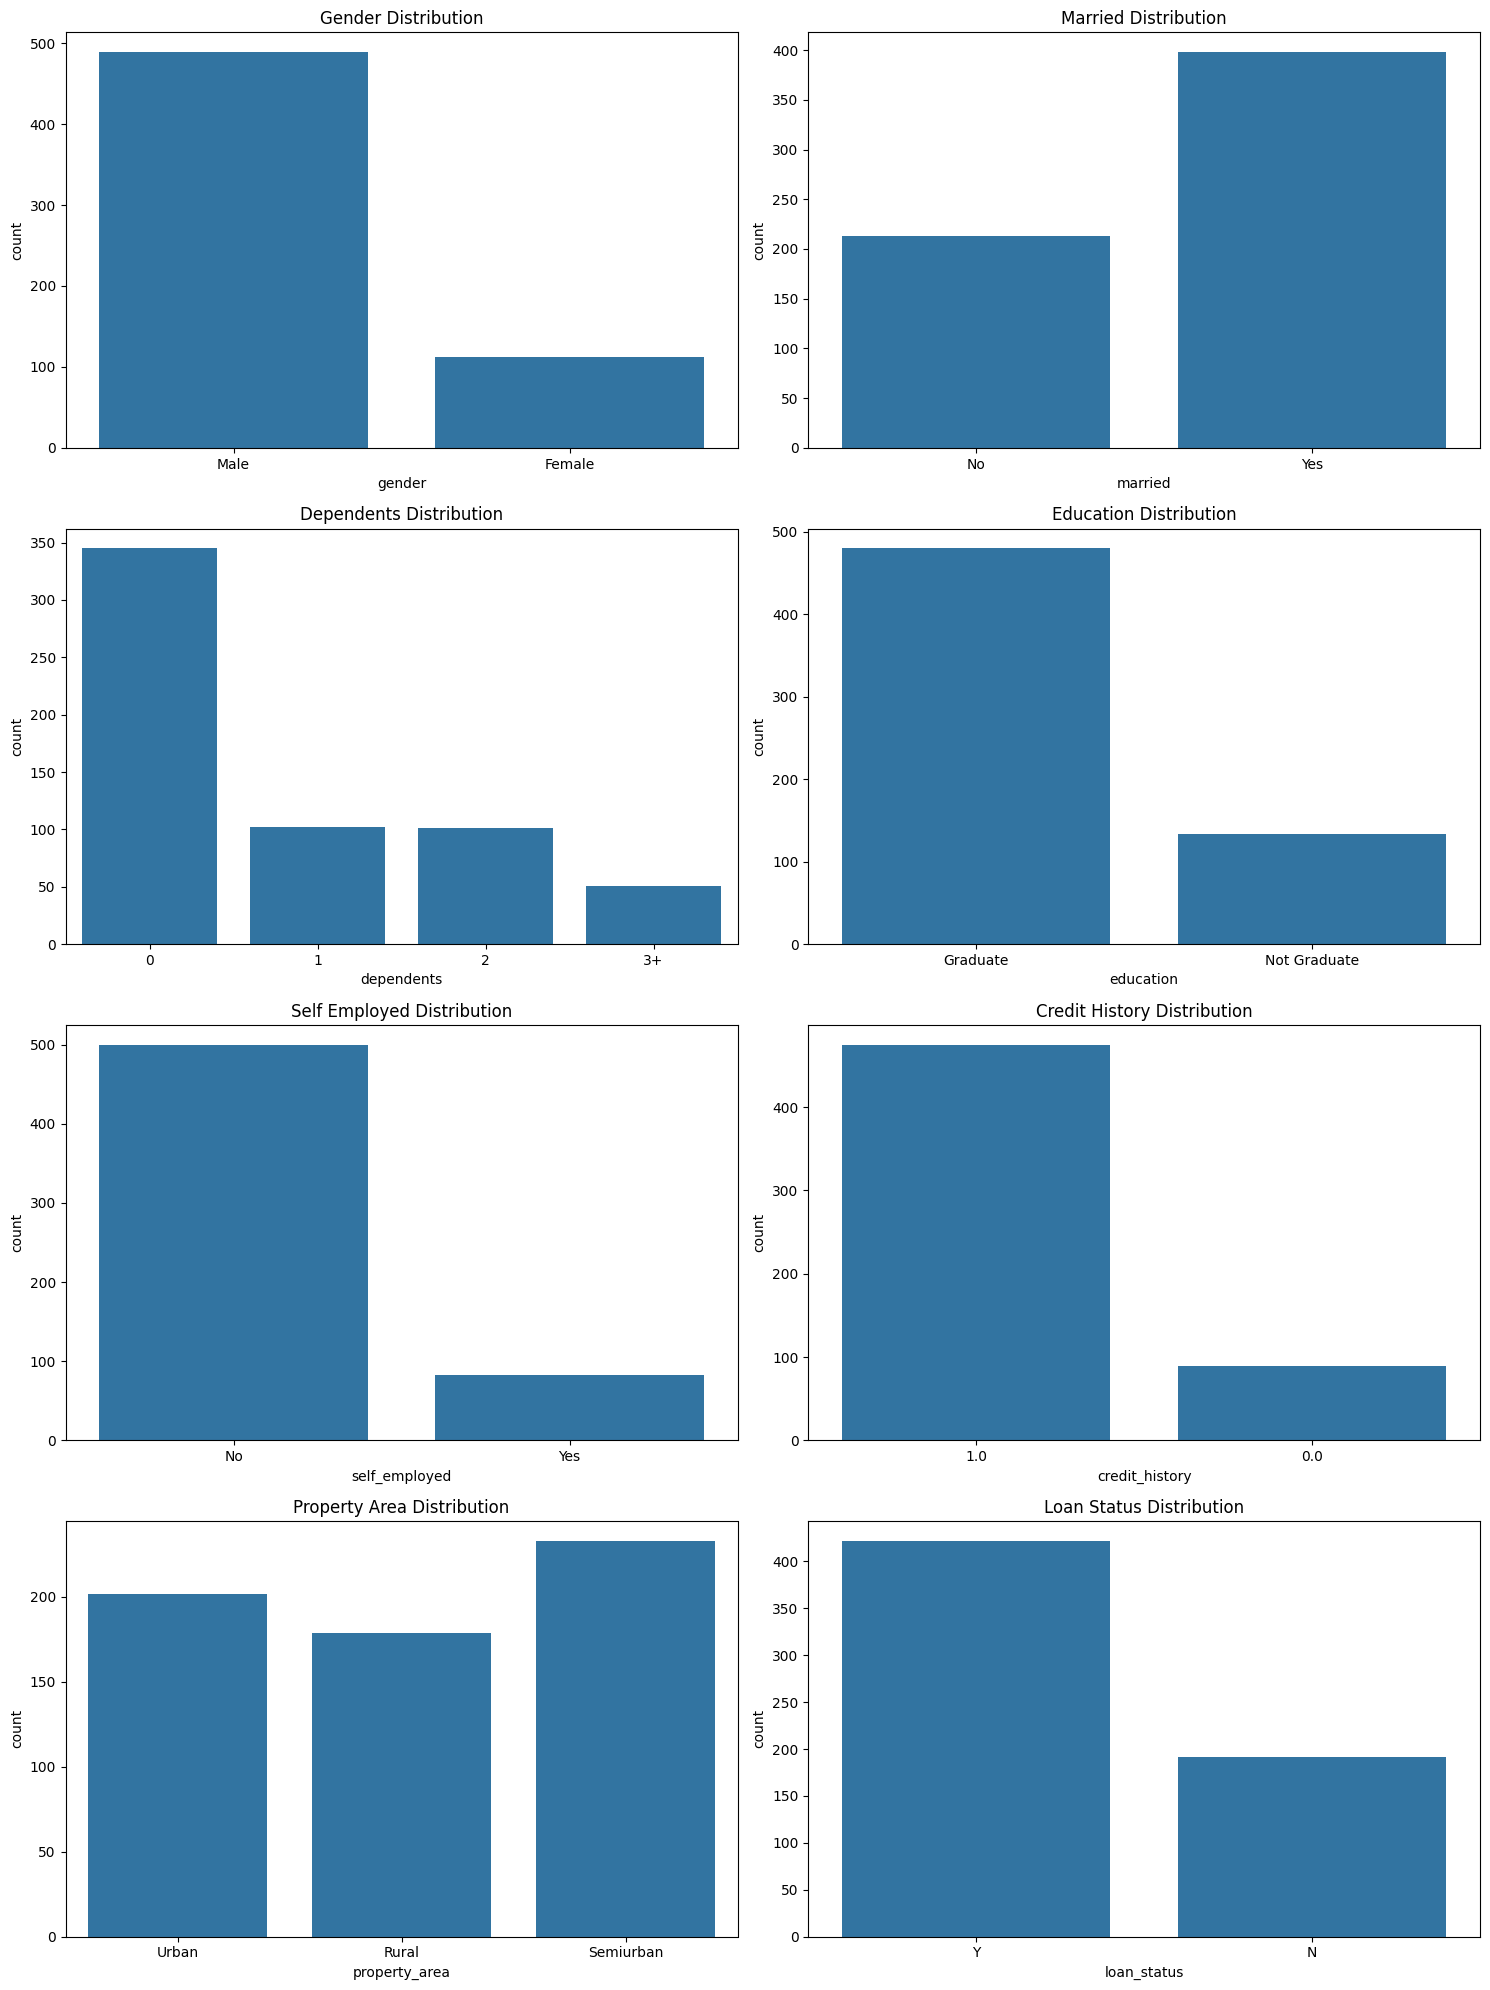

In [21]:
to_neat_column_name = lambda col: ' '.join([word.capitalize() for word in col.split("_")])

num_cols = 2
num_rows = int((len(df_categorical.columns) + 1)/num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 20))

if num_rows == 1:
    axs = [axs]

for i, column in enumerate(df_categorical.columns):
    sns.countplot(x=column, data=df, ax=axs[int(i / num_cols)][i % num_cols])
    axs[int(i / num_cols)][i % num_cols].set_title(f'{to_neat_column_name(column)} Distribution')

plt.tight_layout()
plt.show()


### Numerical Data Overview

In [22]:
df_numeric = df.select_dtypes(exclude=['object', 'boolean'])
print(skim(df_numeric))

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 614    │ │ float64     │ 3     │                                                          │
│ │ Number of columns │ 4      │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name             ┃ NA  ┃ NA %   ┃ mean   ┃ sd     ┃ p0   ┃ p25   ┃ p50   ┃ p75   ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ applicant_income        │   0 │      0 │   5400 │   6100 │  150 │  2900 │  3800 │  5800 │  81000 │    ▇    │  │
│ │ coapplicant_income      │   0 │      0 │   1600 │   2900 │    0 │     0 │  1200 │  2300 │  42000 │    ▇    │  │
│ │ loan_amount             │  22 │   3.58 │    150 │     86 │    9 │   100 │   130 │   170 │    700 │   ▇▇▁   │  │
│ │ loan_amount_term        │  14 │   2.28 │    340 │     65 │   12 │   360 │   360 │   360 │    480 │    ▁ ▇  │  │
│ └─────────────────────────┴─────┴────────┴────────┴────────┴──────┴───────┴───────┴───────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

None


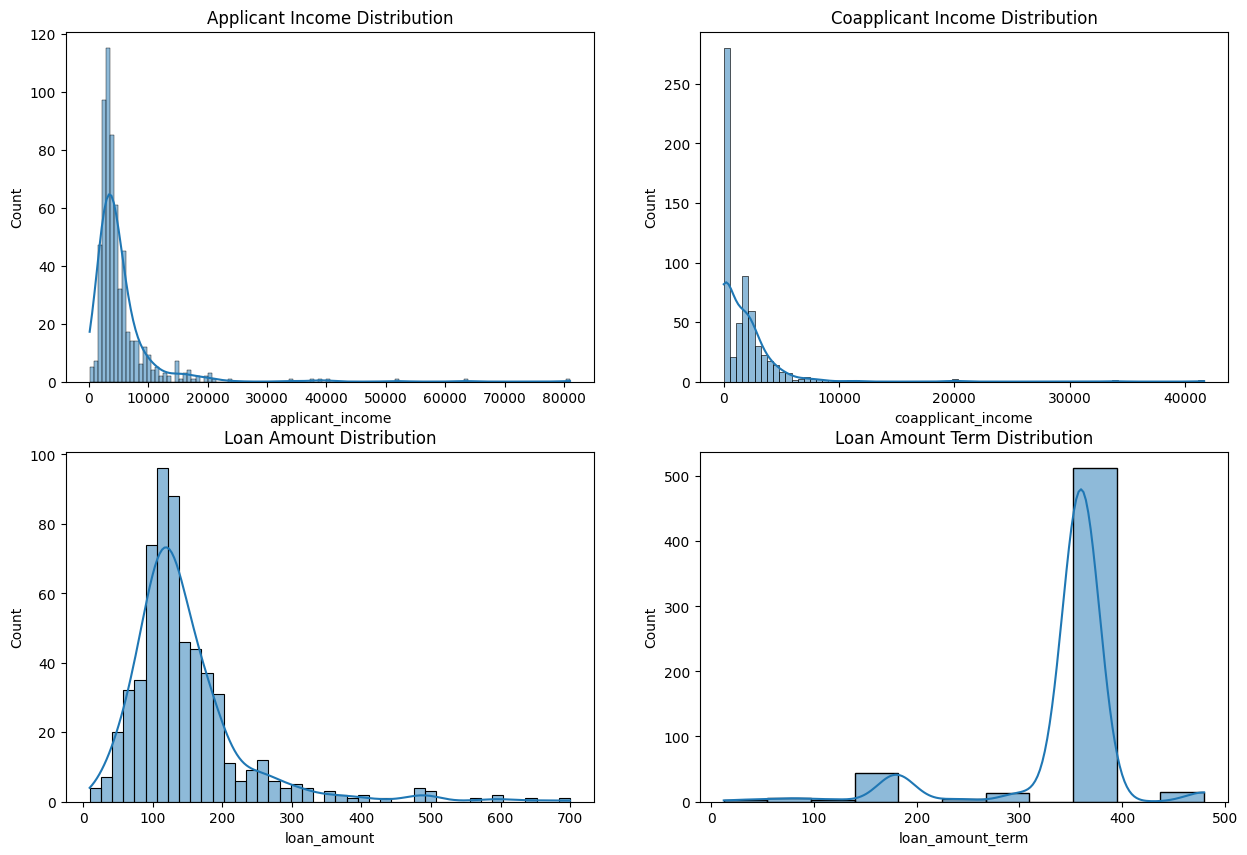

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [23]:
num_cols = 2
num_rows = int((len(df_numeric.columns) + 1)/num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

if num_rows == 1:
    axs = [axs]

for i, column in enumerate(df_numeric.columns):
    plt.figure(figsize=(8, 5))
    sns.histplot(df[column], kde=True, ax=axs[int(i / num_cols)][i % num_cols])
    axs[int(i / num_cols)][i % num_cols].set_title(f'{to_neat_column_name(column)} Distribution')
    
plt.show()


In [24]:
num_cols = 2
num_rows = (len(df_numeric.columns) + num_cols - 1) // num_cols
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=[to_neat_column_name(col) for col in df_numeric.columns])

for i, column in enumerate(df_numeric.columns):
    row = i // num_cols + 1
    col = i % num_cols + 1
    current = fig.add_box(x=df_numeric[column],row=row, col=col, name="")

fig.update_layout(
    title='Numeric Variable Distributions',
    height=800,
    showlegend=False,
    template='plotly_white'
)

fig.show()


NameError: name 'make_subplots' is not defined

,applicant_income,coapplicant_income,loan_amount,loan_amount_term
applicant_income,High,Insignificant,Moderate,Insignificant
coapplicant_income,Insignificant,High,Insignificant,Insignificant
loan_amount,Moderate,Insignificant,High,Insignificant
loan_amount_term,Insignificant,Insignificant,Insignificant,High


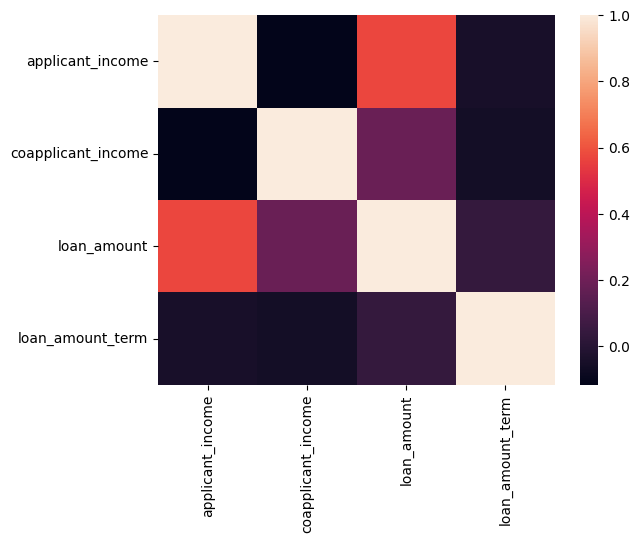

In [25]:
correlation_matrix = df_numeric.corr()
fig = sns.heatmap(data = correlation_matrix)
correlation_matrix.map(lambda x: "High" if abs(x) > 0.7 else "Moderate" if abs(x) > 0.5 else "Low" if abs(x) > 0.3 else "Insignificant")

There does exist a moderate correlation between `loan_amount` and `applicant_income` which will be examined

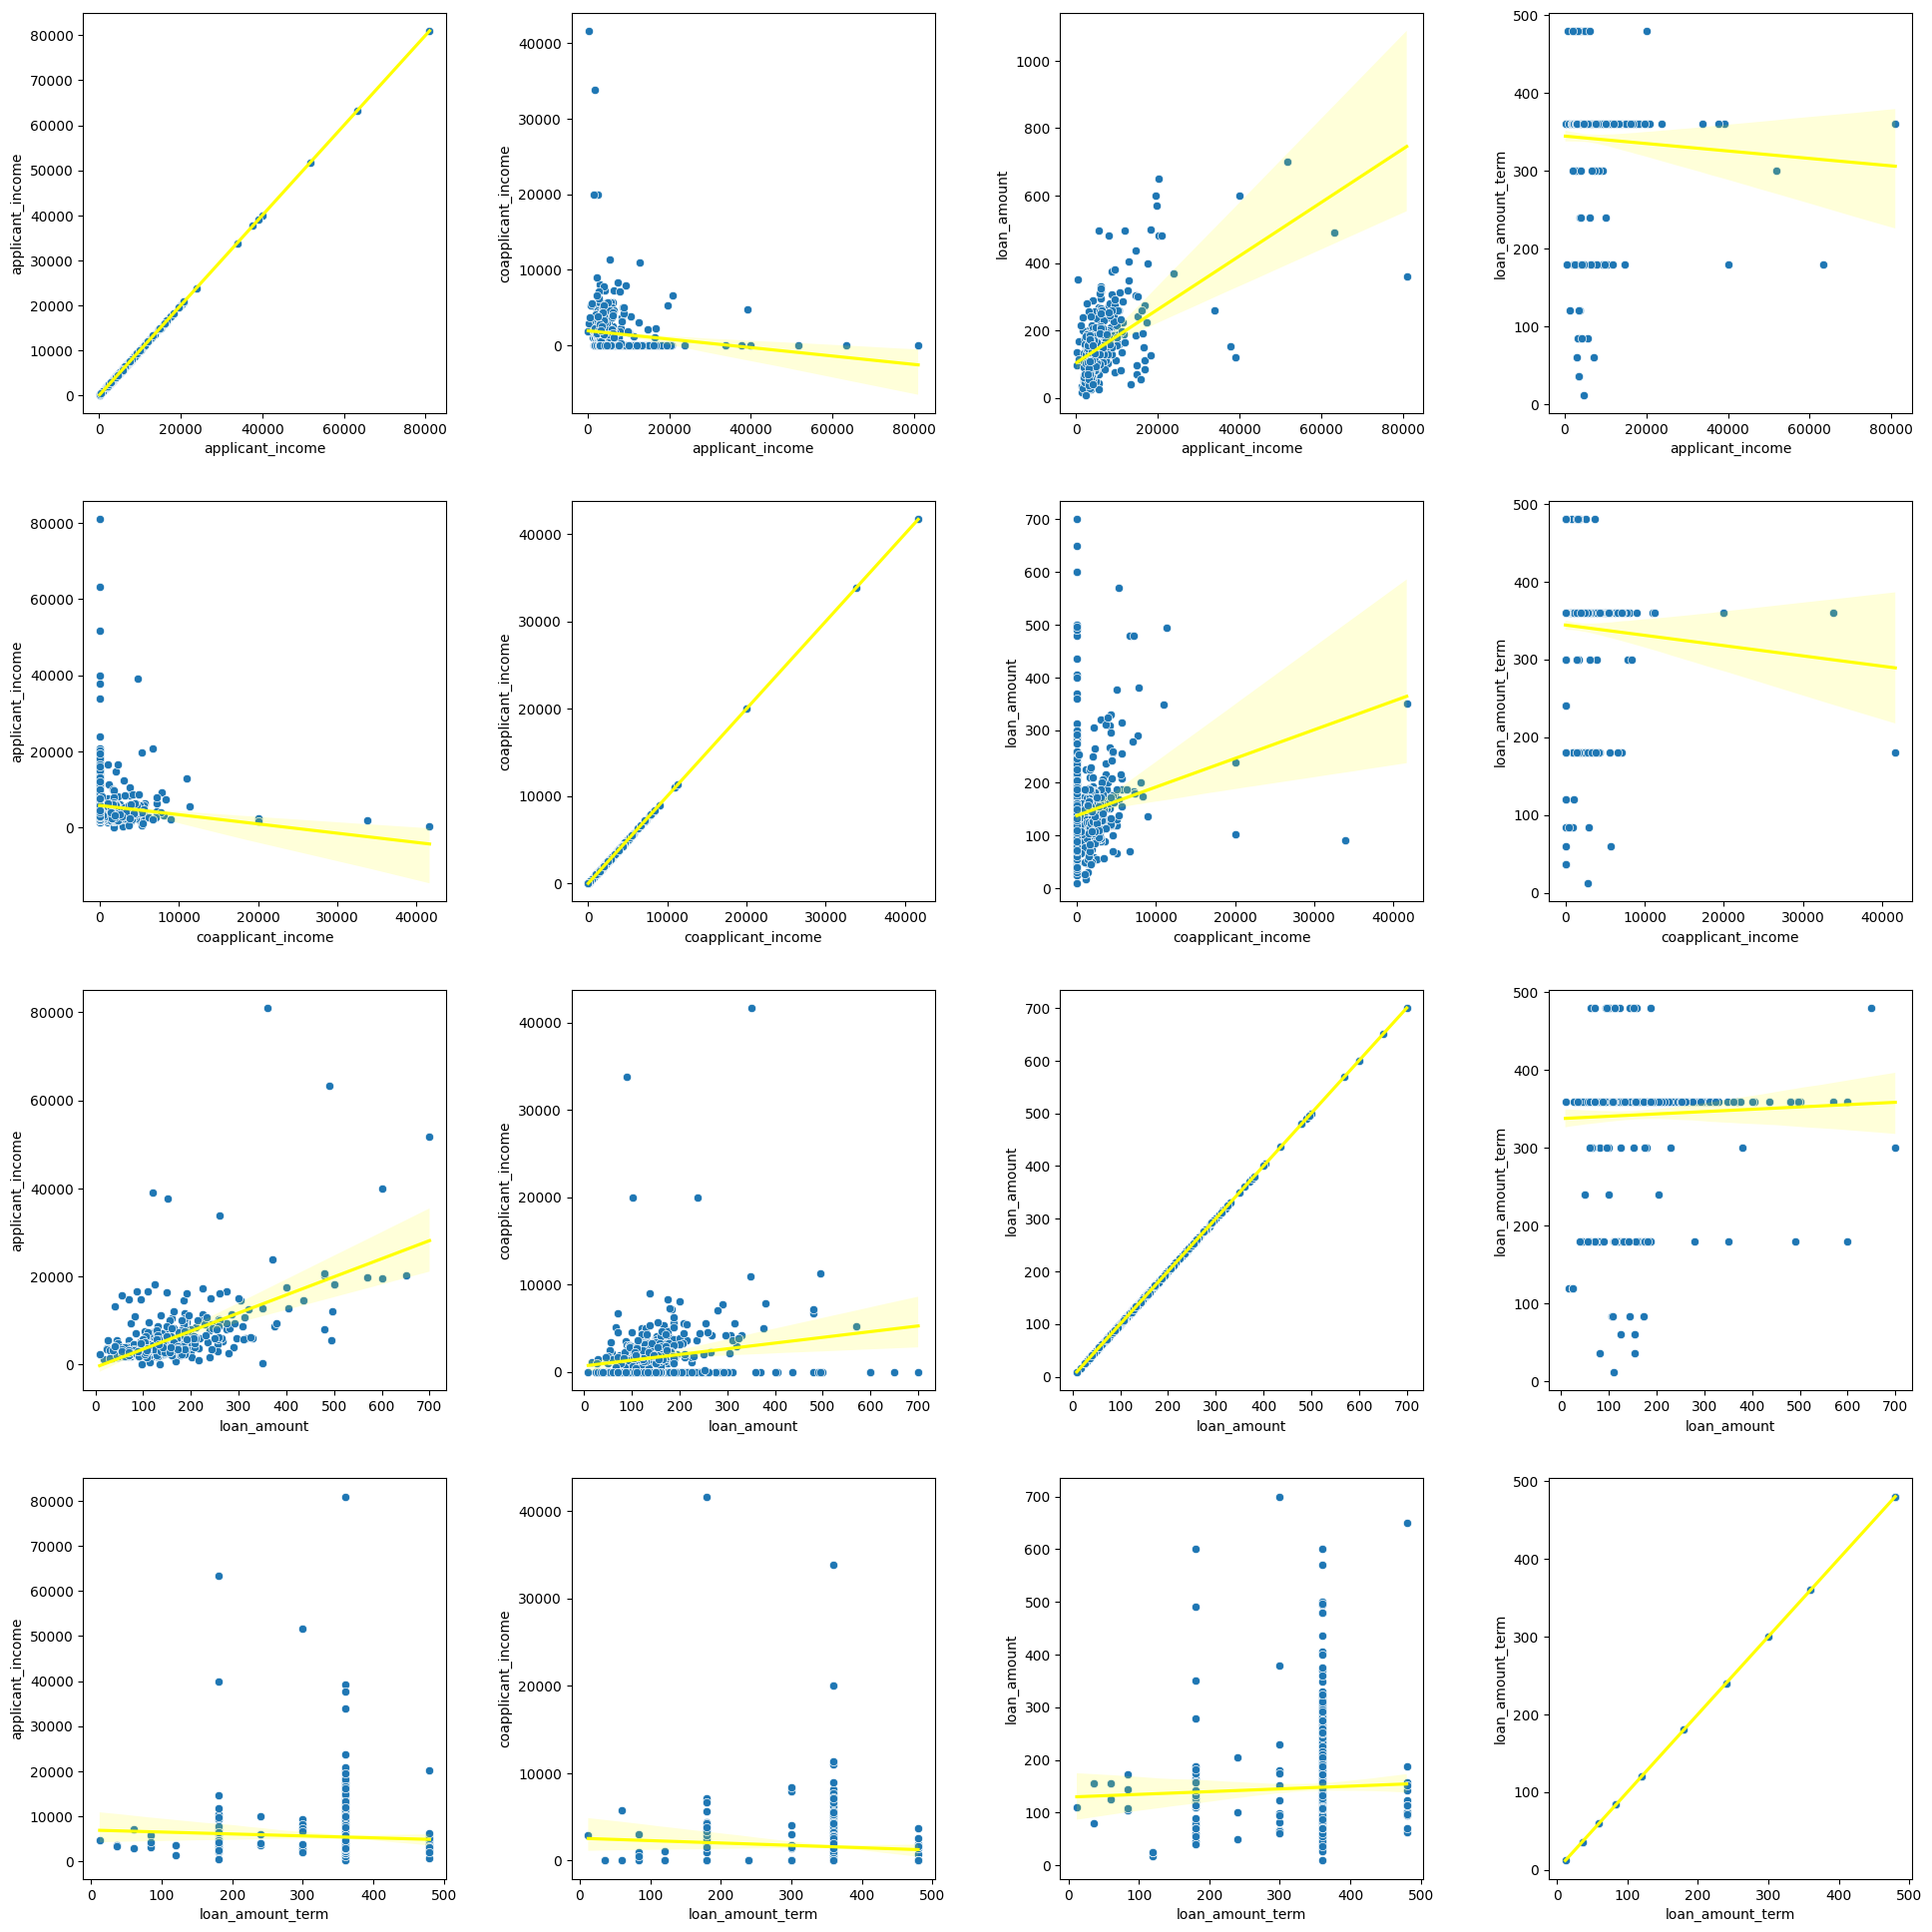

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = len(df_numeric.columns)
num_rows = len(df_numeric.columns)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

if num_rows == 1:
    axs = [axs]

for i, columnA in enumerate(df_numeric.columns):
    for j, columnB in enumerate(df_numeric.columns):
        # Plot scatter plot with regression line
        ax = sns.scatterplot(x=df_numeric[columnA], y=df_numeric[columnB], ax=axs[i][j])
        sns.regplot(x=df_numeric[columnA], y=df_numeric[columnB], scatter=False, ax=ax, color="yellow")

fig.tight_layout(pad=3.0)
plt.show()

    

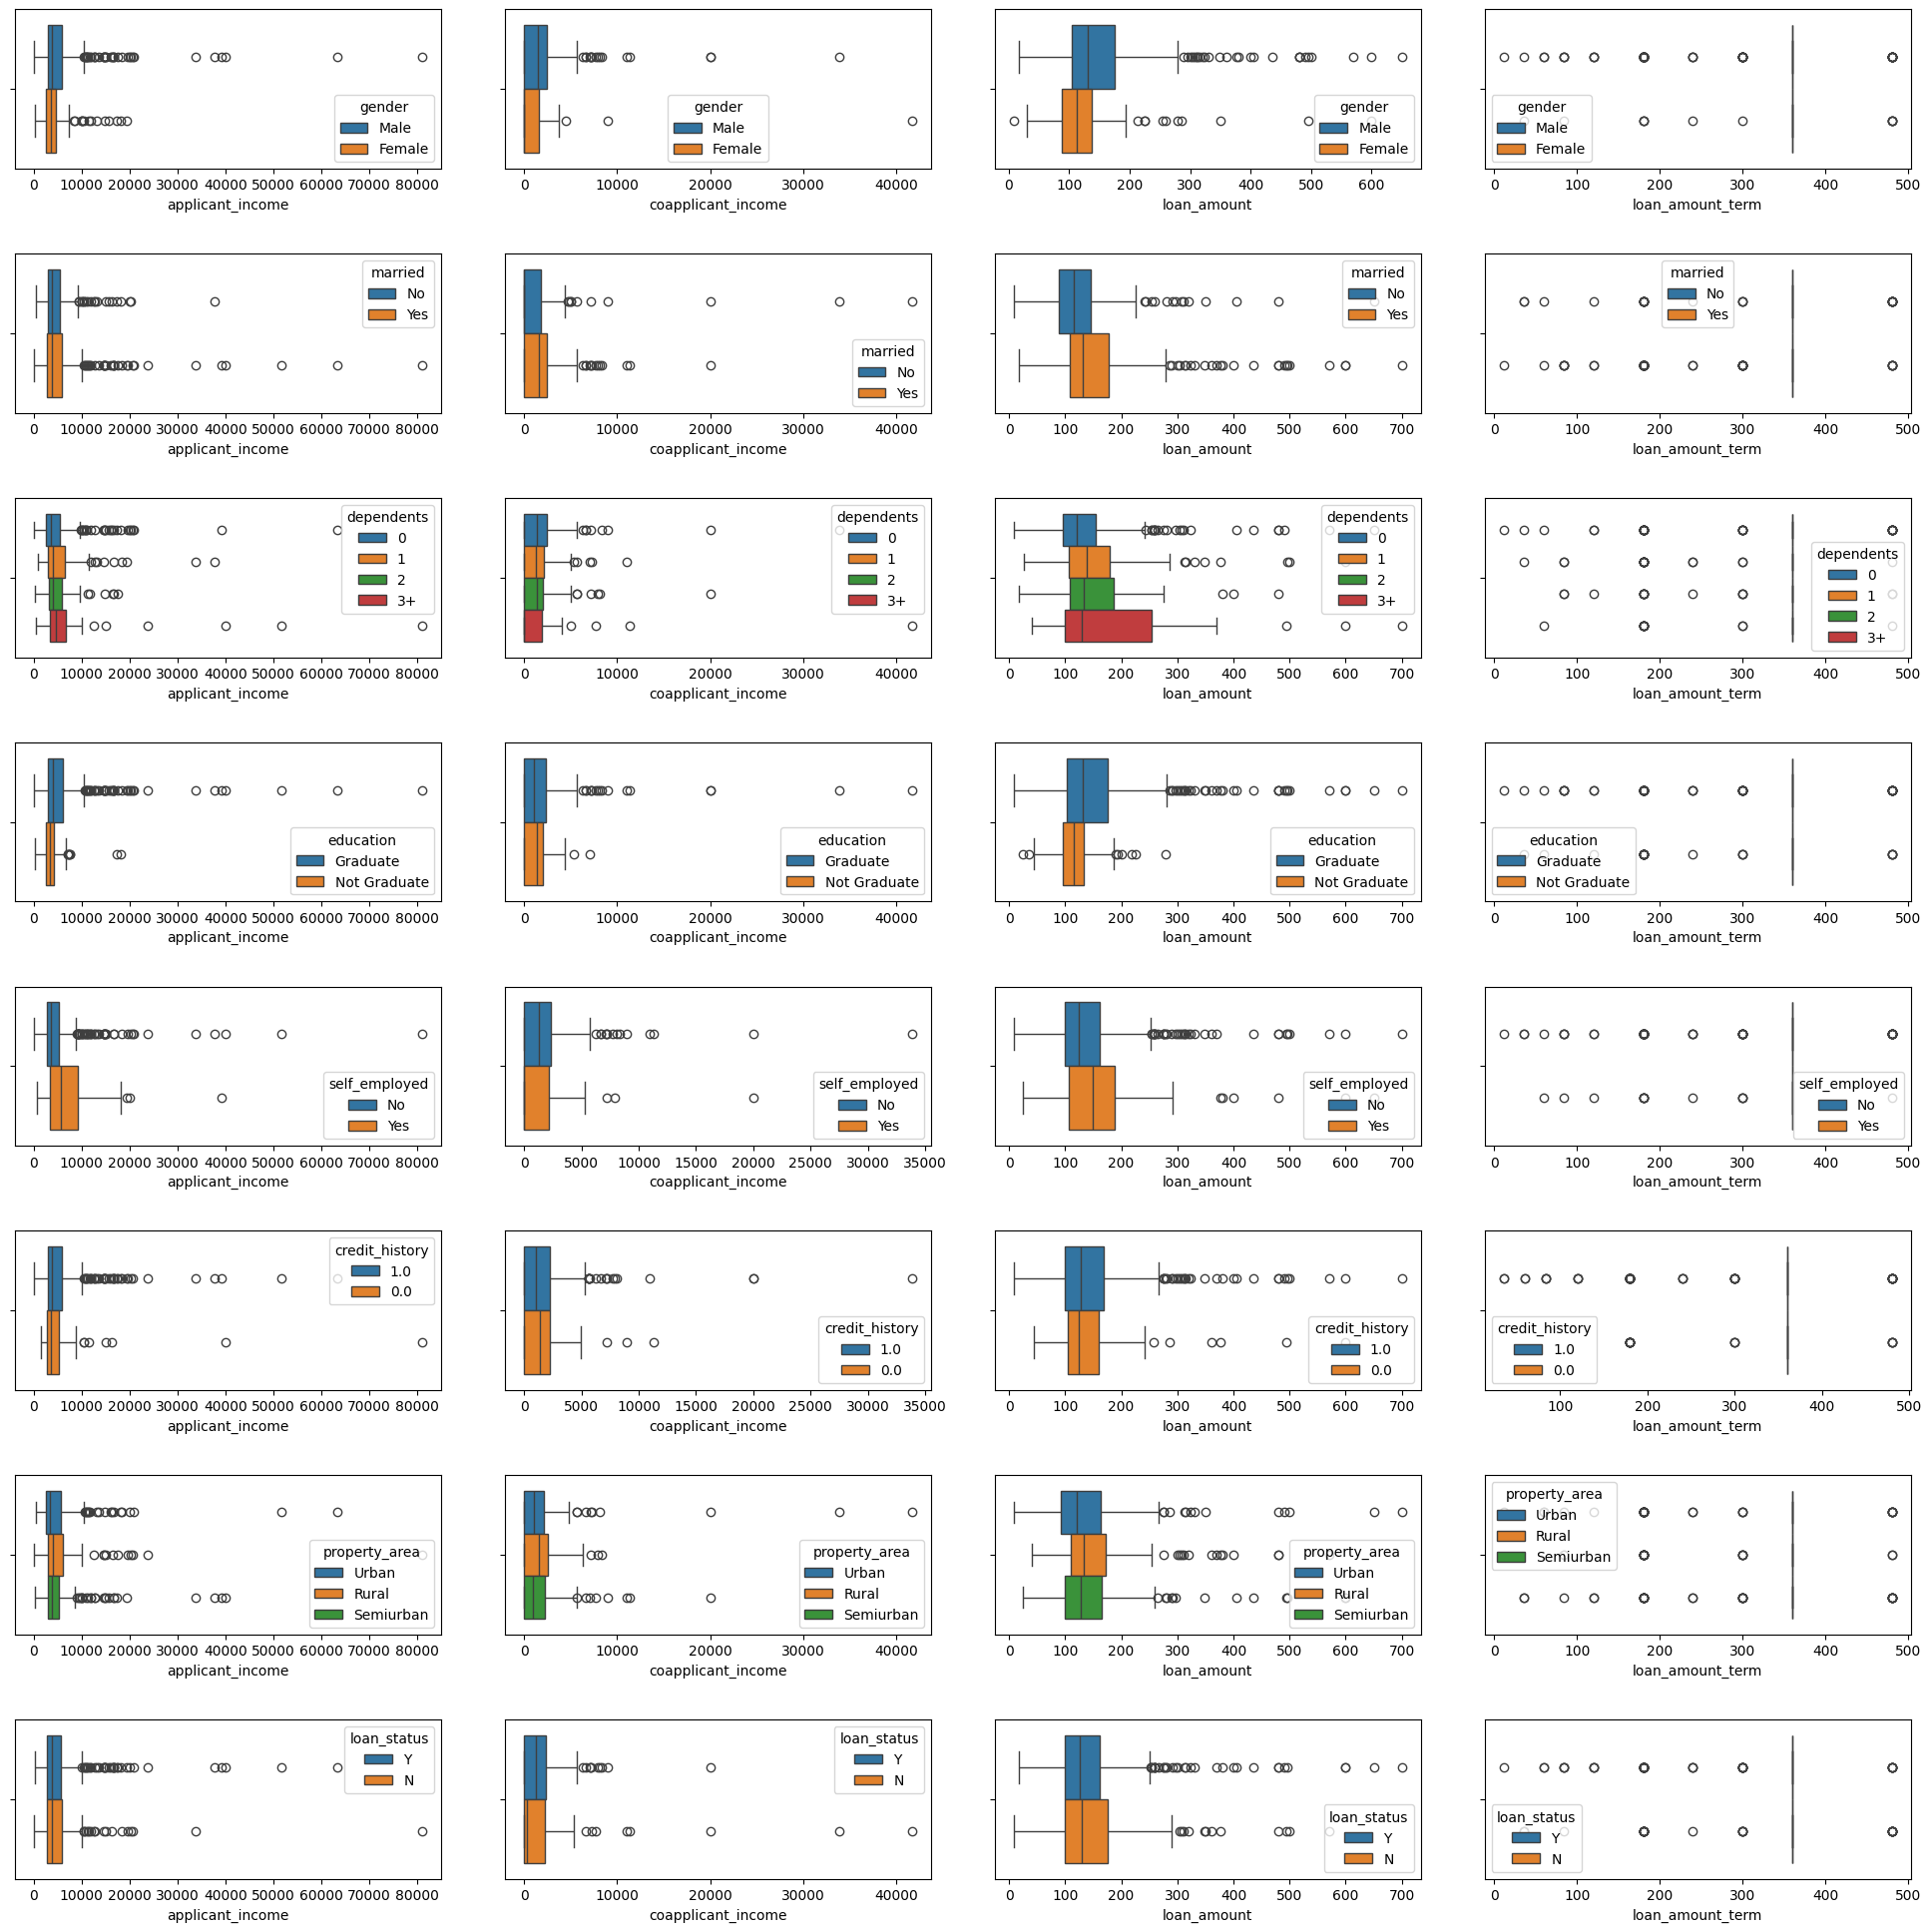

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = len(df_numeric.columns)
num_rows = len(df_categorical.columns)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

if num_rows == 1:
    axs = [axs]

for i, columnA in enumerate(df_categorical.columns):
    for j, columnB in enumerate(df_numeric.columns):
        ax = sns.boxplot(data=df, x=columnB, hue=columnA, ax=axs[i][j])

fig.tight_layout(pad=3.0)
plt.show()


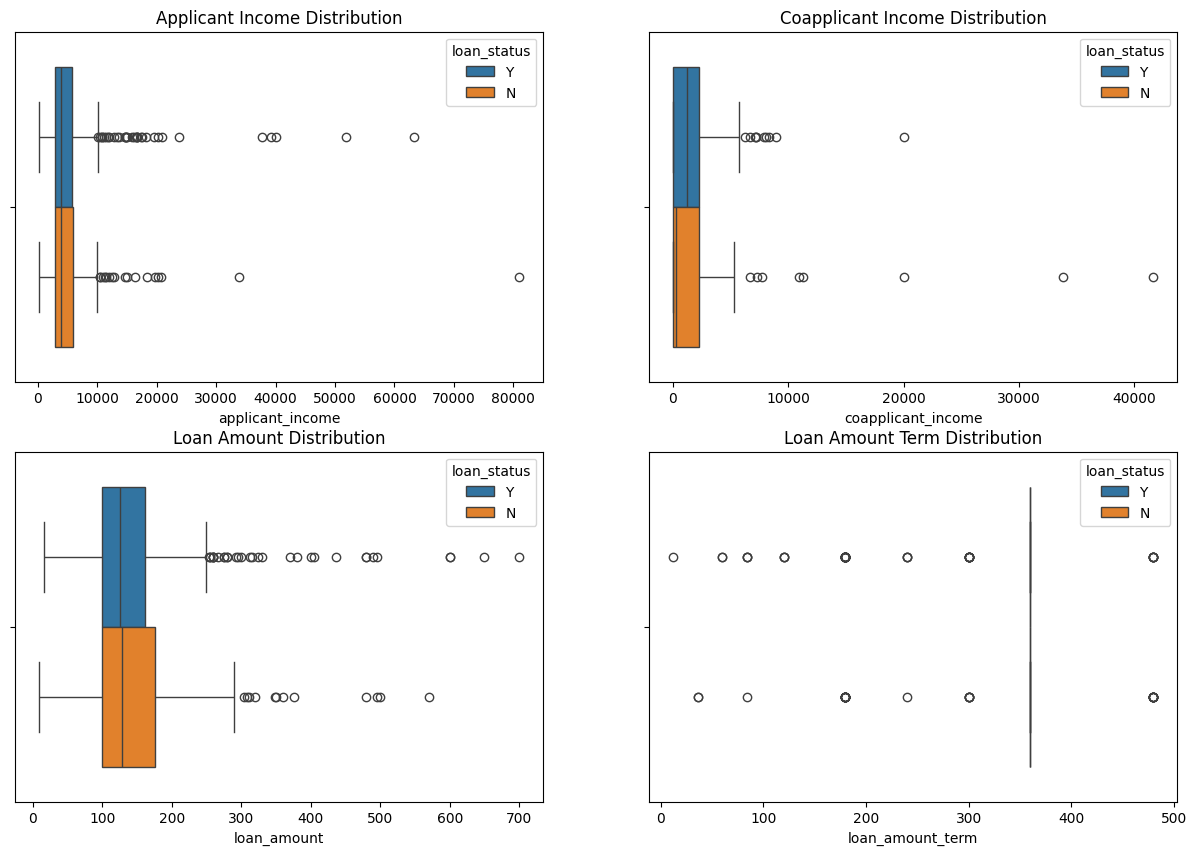

In [28]:
num_cols = 2
num_rows = int((len(df_numeric.columns) + 1)/num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

if num_rows == 1:
    axs = [axs]

for i, column in enumerate(df_numeric.columns):
    sns.boxplot(data=df, x=column, ax=axs[int(i / num_cols)][i % num_cols], hue='loan_status')
    axs[int(i / num_cols)][i % num_cols].set_title(f'{to_neat_column_name(column)} Distribution')
    
plt.show()

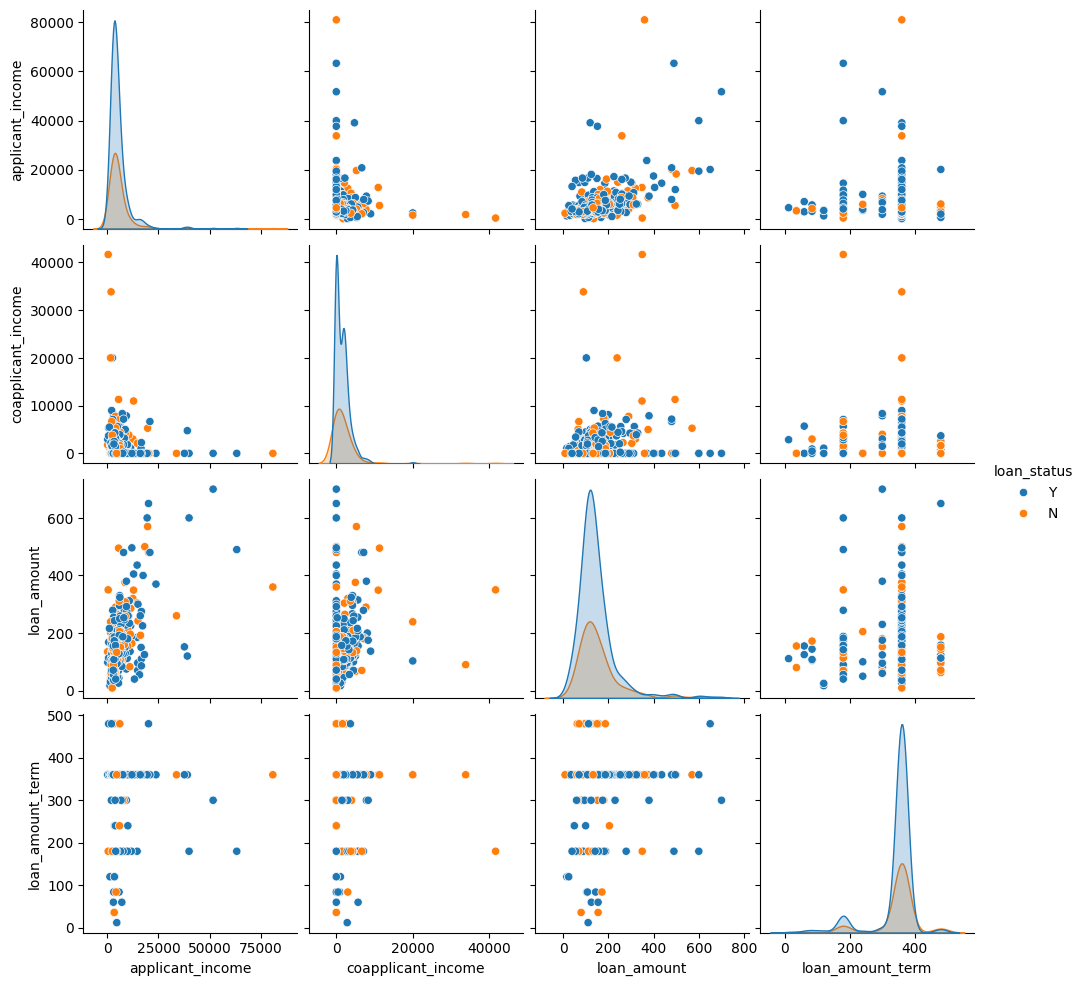

In [29]:
sns.pairplot(data=df, hue="loan_status")

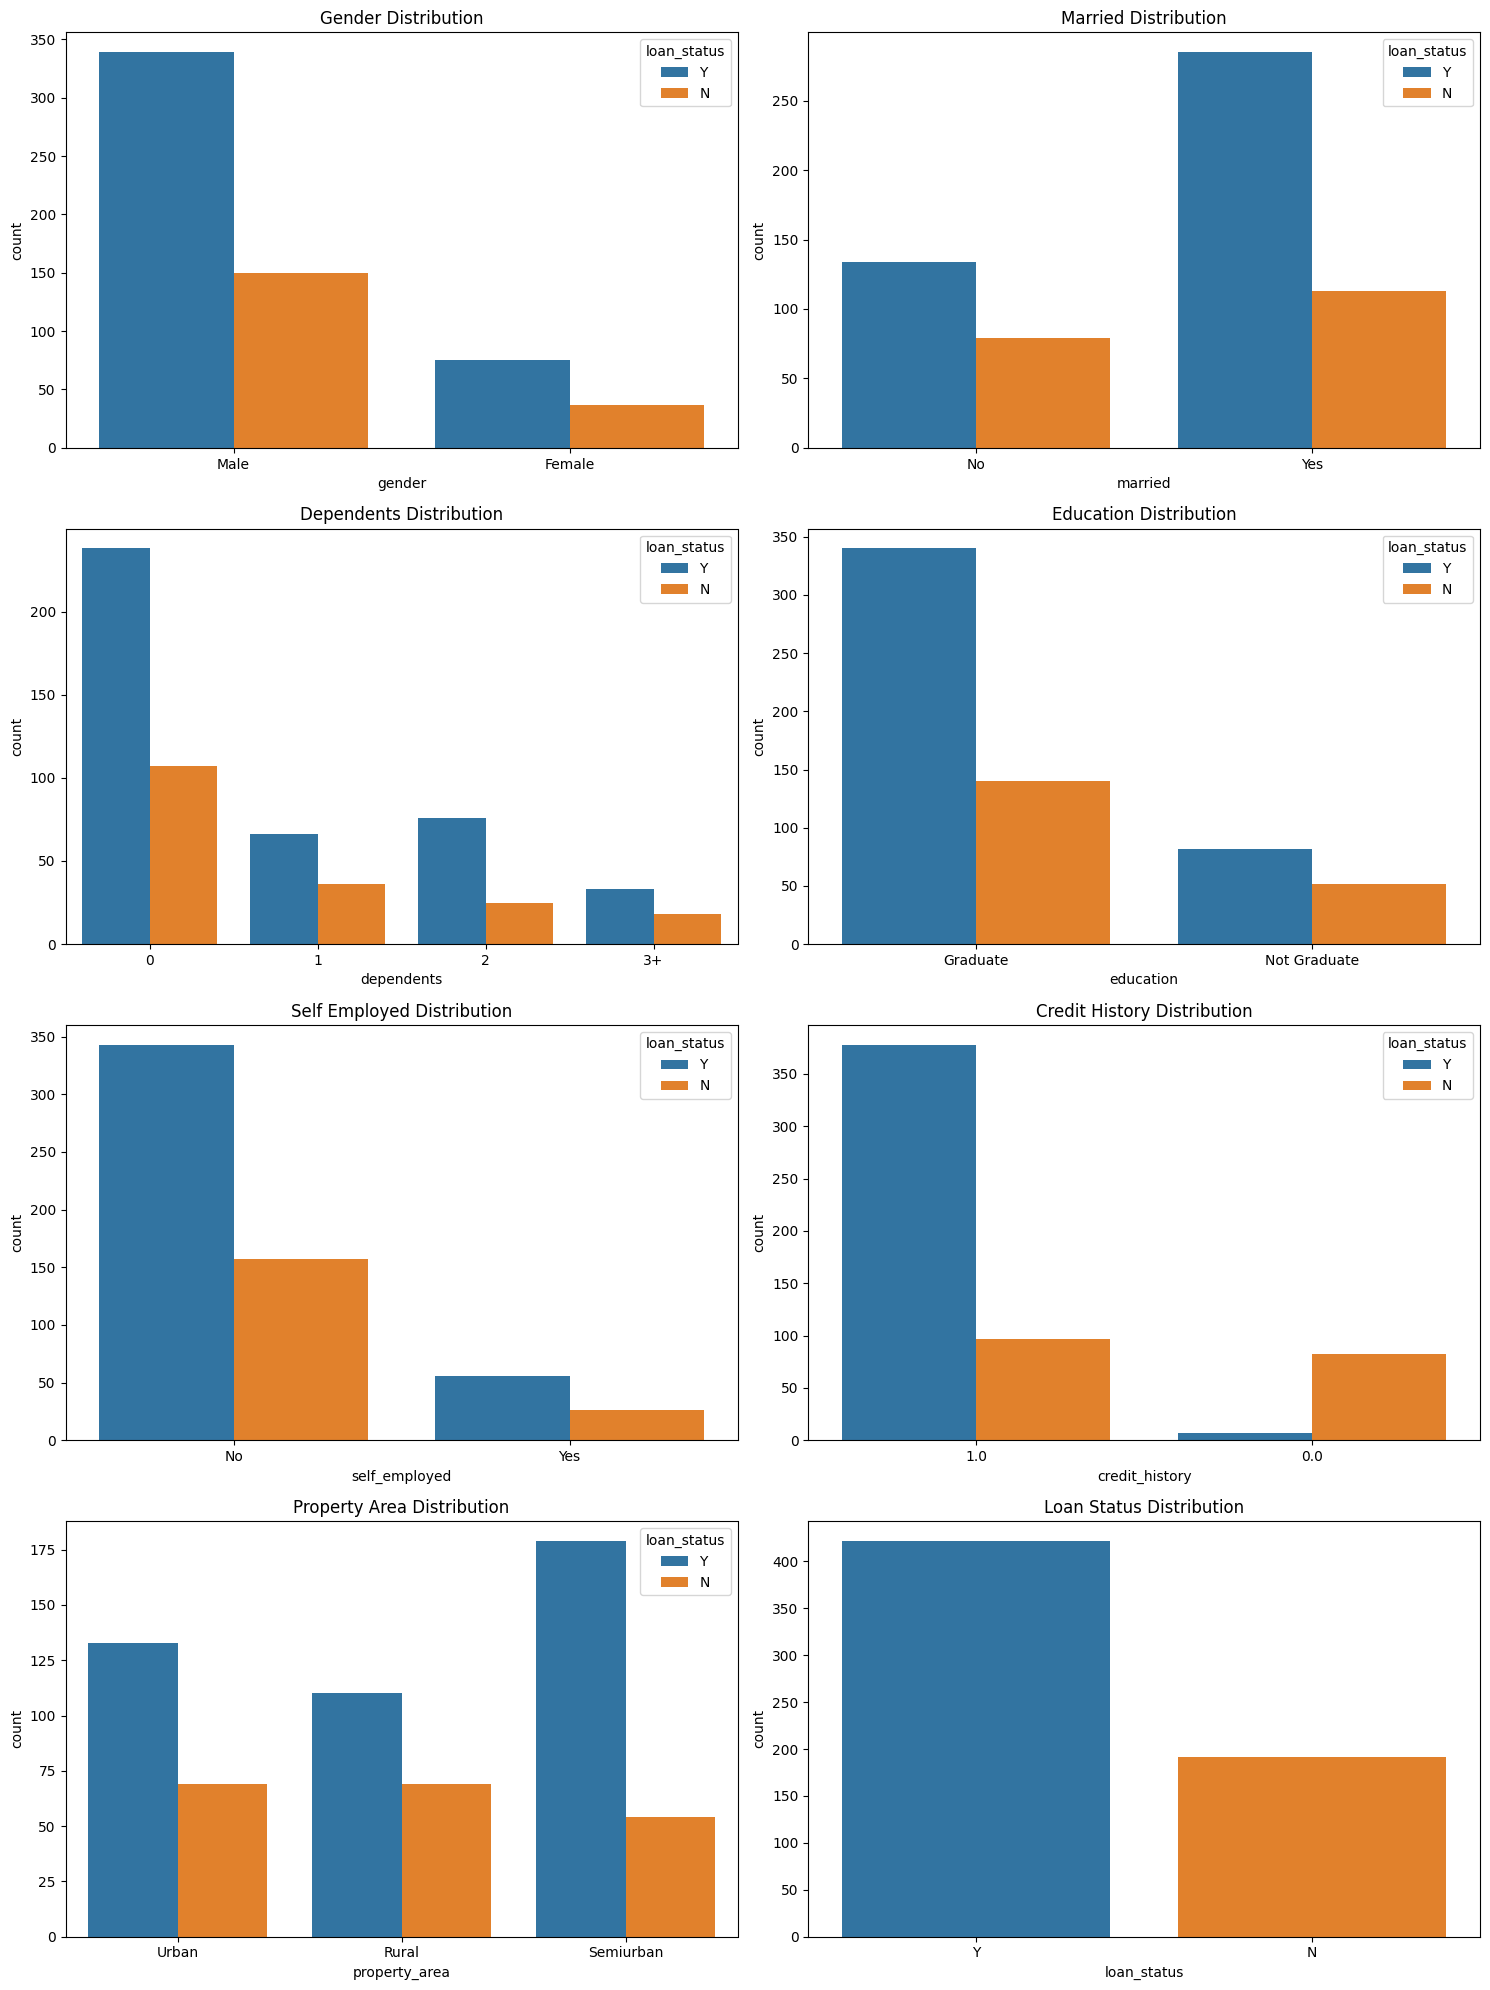

In [31]:
num_cols = 2
num_rows = int((len(df_categorical.columns) + 1)/num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 20))

if num_rows == 1:
    axs = [axs]

for i, column in enumerate(df_categorical.columns):
    sns.countplot(x=column, data=df, ax=axs[int(i / num_cols)][i % num_cols], hue='loan_status')
    axs[int(i / num_cols)][i % num_cols].set_title(f'{to_neat_column_name(column)} Distribution')

plt.tight_layout()
plt.show()

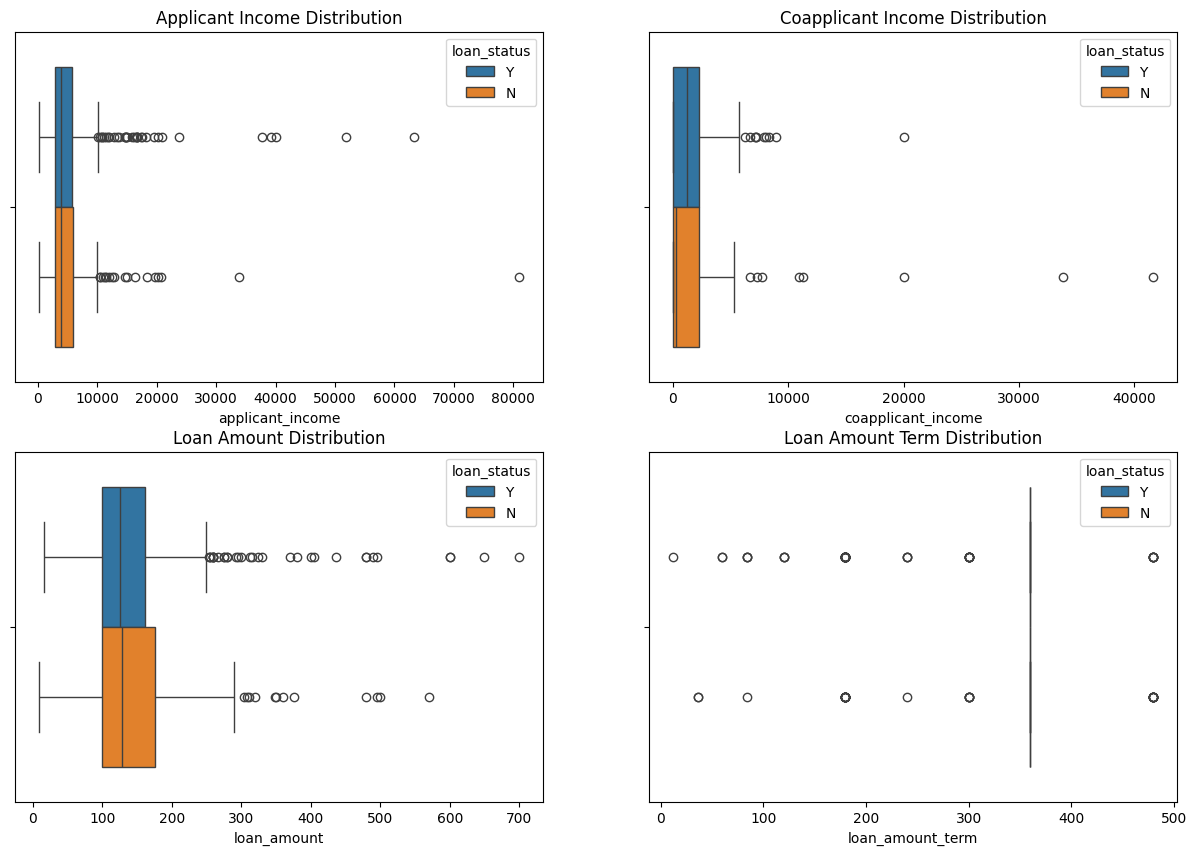

In [32]:
num_cols = 2
num_rows = int((len(df_numeric.columns) + 1)/num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

if num_rows == 1:
    axs = [axs]

for i, column in enumerate(df_numeric.columns):
    sns.boxplot(data=df, x=column, ax=axs[int(i / num_cols)][i % num_cols], hue='loan_status')
    axs[int(i / num_cols)][i % num_cols].set_title(f'{to_neat_column_name(column)} Distribution')
    
plt.show()

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score
import pandas as pd
import numpy as np
import tensorflow as tf

to_binary = lambda data: pd.DataFrame(data).apply(lambda col: col.map(lambda v: int("y" in str(v).lower() or "1" in str(v).lower())))

X = df.drop(columns=['loan_status'], axis=1)
y = df['loan_status'].apply(lambda v: int("y" in str(v).lower() or "1" in str(v).lower()))

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
ordinal_features = ['dependents']
binary_features = ['married', 'self_employed', 'credit_history']
categorical_features = ['gender', 'education', 'property_area']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values appropriately
    ('encoder', FunctionTransformer(to_binary)),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('bin', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features)
    ])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='softmax'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ]))
])

clf.named_steps['classifier'].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


gen_num_epochs = lambda i: (i+1) * 5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1024)

def get_model_accuracy(model, X_train, X_test, y_train, y_test, epochs, batch_size):
    model.fit(X_train, y_train, classifier__epochs=epochs, classifier__batch_size=batch_size)
    binary_accuracy = make_scorer(lambda y, y_pred: accuracy_score(y, (y_pred > 0.5).astype(int).flatten()), greater_is_better=True)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_scores = cross_val_score(clf, X_test, y_test, scoring=binary_accuracy, cv=kfold)
    train_scores = cross_val_score(clf, X_train, y_train, scoring=binary_accuracy, cv=kfold)
    return (np.mean(train_scores), np.mean(test_scores))
    
tests = []
trains = []
for i in range(5):
    (train_accuracy, test_accuracy) = get_model_accuracy(clf, X_train, X_test, y_train, y_test, epochs=(i+1) *5, batch_size=32)
    tests += [test_accuracy]
    trains += [train_accuracy]

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3114 - loss: 0.7190
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5308 - loss: 0.6885 
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7085 - loss: 0.6545 
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7115 - loss: 0.6176 
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6771 - loss: 0.6197 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6962 - loss: 0.6089  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6837 - loss: 0.6196  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6776 - loss: 0.6159  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7184 - loss: 0.5944  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6955 - loss: 0.6052  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━

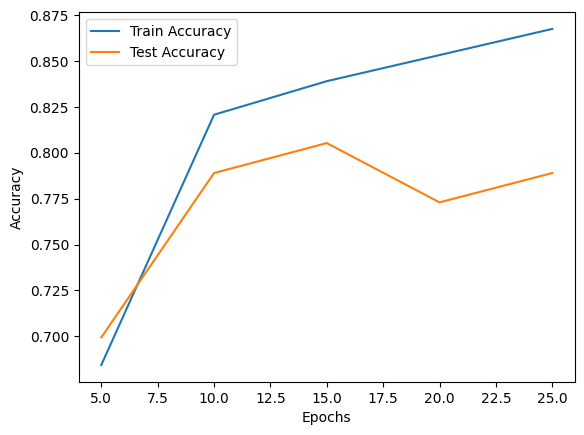

In [55]:
tests_df = pd.DataFrame({'Accuracy': tests, 'Epochs': [gen_num_epochs(i) for i in range(len(tests))]})
trains_df = pd.DataFrame({'Accuracy': trains, 'Epochs': [gen_num_epochs(i) for i in range(len(tests))]})
fig = sns.lineplot(data=trains_df, x='Epochs', y='Accuracy', label="Train Accuracy")
sns.lineplot(data=tests_df, x='Epochs', y='Accuracy', ax=fig, label = "Test Accuracy")
fig.legend()
plt.show()

## Most Optimal Combination
- Epochs: 15
- Batch Size: 32

In [ ]:
32